In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
sns.set_context('talk')
sns.set_style('ticks')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
sim_name = 'test_schedule_v7'
outdir = f'fig/{sim_name}'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [4]:
%run ../bin/analyze_sim.py test_schedule_v7


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]
/Users/ebellm/anaconda3/envs/ztf_sim/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Simulation Name	test_schedule_v7
Number of Nights	274
Nights completely weathered out	65
Average Hours of Darkness	9.315612904074852
Total Science Time (h)	1463.544238795485
Average Science Time per night (h)	5.341402331370383
Fraction of time usable	0.5733817394917663
Average Number of Exposures per hour	81.54656131079717
Open Shutter Fraction	0.6782594738763953
Mean Time Between Exposures (s)	14.23086024666003
Mean Slew Distance (deg)	9.310018197994042
90% Time Between Exposures (s)	16.478572003543377
90% Slew Distance (deg)	15.078197937363033
Median Airmass	1.1140699322383127
90% Airmass	1.5544640387341593
Program Fraction	{1: 0.39995140221371295, 2: 0.39571166430660176, 3: 0.20433693347968529}
Filter Fraction	{'g': 0.37815780874257415, 'i': 0.051212012032141568, 'r': 0.57063017922528425}
Average Nightly Filter Exchanges	10.669856459330143
Average Filter Exchanges per hour	1.523698389763276
Sequence Completion Fraction by Program	{1: 0.83883382539013074, 2: 0.90517599958405071, 3: 0

In [5]:
df = df_read_from_sqlite(sim_name, tablename='Summary', directory='sims')

In [6]:
df.columns

Index(['obsHistID', 'requestID', 'propID', 'fieldID', 'fieldRA', 'fieldDec',
       'filter', 'expDate', 'expMJD', 'night', 'visitTime', 'visitExpTime',
       'FWHMgeom', 'FWHMeff', 'airmass', 'filtSkyBright', 'lst', 'altitude',
       'azimuth', 'dist2Moon', 'solarElong', 'moonRA', 'moonDec', 'moonAlt',
       'moonAZ', 'moonPhase', 'sunAlt', 'sunAz', 'slewDist', 'slewTime',
       'fiveSigmaDepth', 'totalRequestsTonight', 'metricValue', 'subprogram'],
      dtype='object')

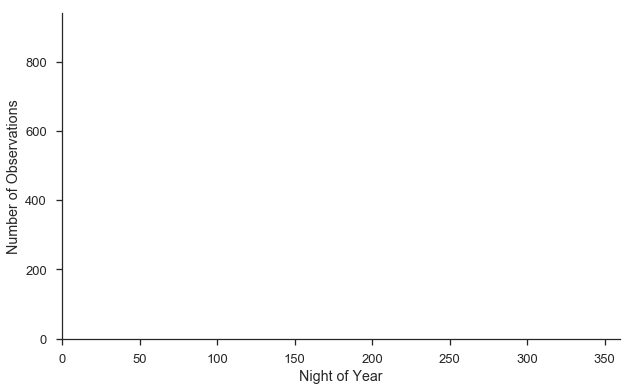

In [7]:
grp_night = df.groupby('night')
nobs_night = grp_night['expDate'].agg(len)
plt.bar(nobs_night.index, nobs_night.values)
plt.xlabel('Night of Year')
plt.ylabel('Number of Observations')
plt.xlim(0,360)
sns.despine()
plt.savefig(f'fig/{sim_name}/nobs_bynight.png')

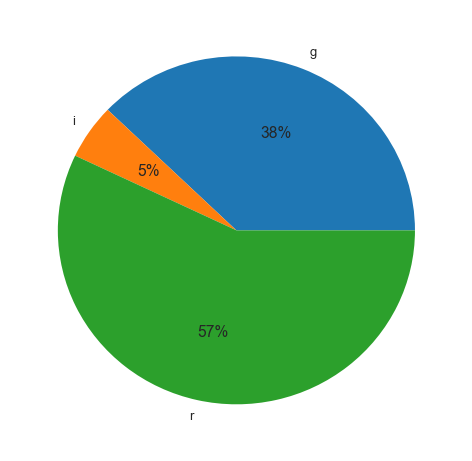

In [8]:
plt.figure(figsize=(8,8))
grp_filter = df.groupby('filter')
nobs_perfilter = grp_filter['expDate'].agg(len)
plt.pie(nobs_perfilter, labels=nobs_perfilter.index, autopct='%.0f%%')
plt.savefig(f'fig/{sim_name}/nobs_byfilter.png')

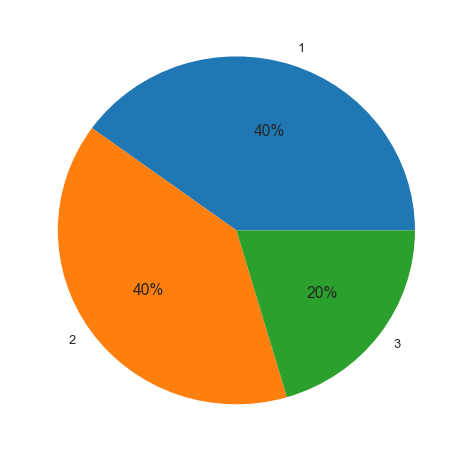

In [9]:
plt.figure(figsize=(8,8))
grp_program = df.groupby('propID')
nobs_perprogram = grp_program['expDate'].agg(len)
plt.pie(nobs_perprogram, labels=nobs_perprogram.index, autopct='%.0f%%')
plt.savefig(f'fig/{sim_name}/nobs_byprogram.png')

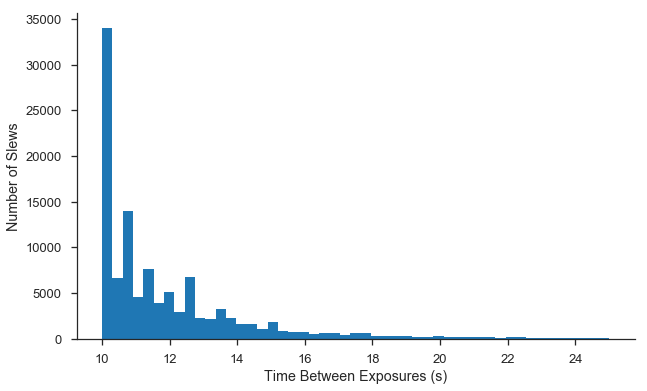

In [10]:
plt.hist(df.loc[df.slewTime.notnull(),'slewTime'],bins=np.linspace(10,25,50))
plt.xlabel('Time Between Exposures (s)')
plt.ylabel('Number of Slews')
sns.despine()
plt.savefig(f'fig/{sim_name}/slew_time_hist.png')

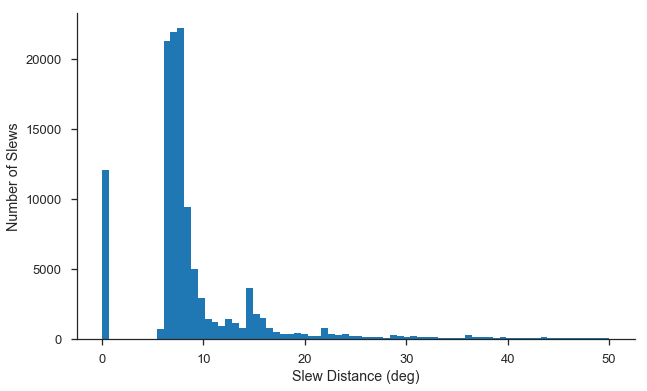

In [11]:
plt.hist(np.degrees(df.loc[df.slewTime.notnull(),'slewDist']),bins=np.linspace(0,50,75))
plt.xlabel('Slew Distance (deg)')
plt.ylabel('Number of Slews')
sns.despine()
plt.savefig(f'fig/{sim_name}/slew_distance_hist.png')

In [12]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///../data/ptf.db')
ptf_df = pd.read_sql('Summary', engine)

In [13]:
from astropy.time import Time
iptf_start = Time('2013-01-01').mjd
wiptf = ptf_df.expMJD >= iptf_start

In [14]:
ptf_df.columns

Index(['obsHistID', 'propID', 'fieldID', 'filter', 'expMJD', 'night',
       'visitExpTime', 'airmass', 'lst', 'altitude', 'azimuth', 'moonRA',
       'moonDec', 'moonAlt', 'moonPhase', 'wind', 'humidity', 'finSeeing',
       'filtSkyBrightness', 'fiveSigmaDepth', 'sessionID', 'fieldRA',
       'fieldDec', 'expDate', 'rotSkyPos', 'ditheredRA', 'ditheredDec'],
      dtype='object')

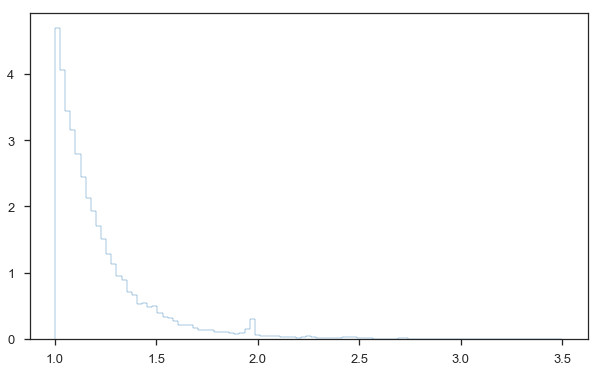

In [15]:
_ = plt.hist(ptf_df[wiptf].airmass,bins=np.linspace(1,3.5,100),histtype='step',normed=True, label='iPTF')

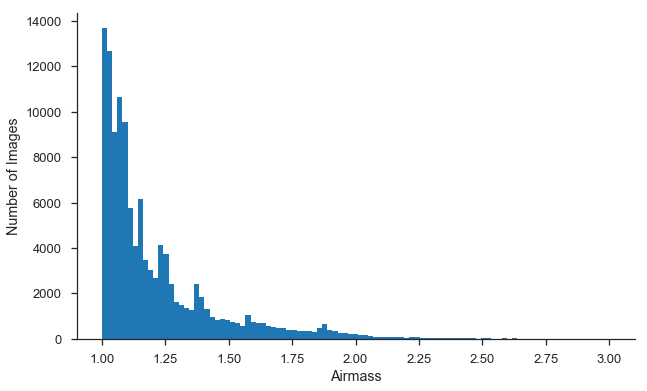

In [16]:
plt.hist(df.airmass,bins=np.linspace(1,3,100))
plt.xlabel('Airmass')
plt.ylabel('Number of Images')
sns.despine()
plt.savefig(f'fig/{sim_name}/airmass_hist.png')

In [17]:
print(df.airmass.max())

5.68601092516


In [18]:
print(np.sum(df.airmass > 2.5))

121


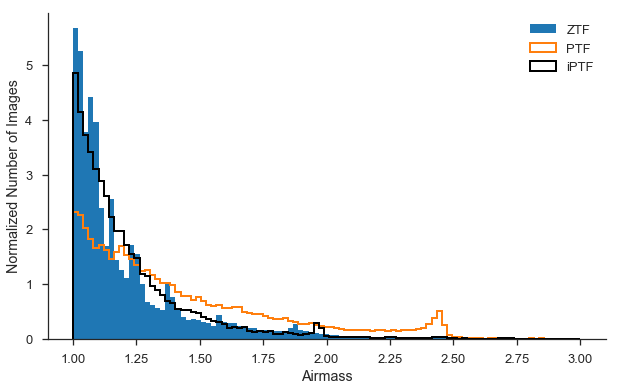

In [19]:
bins = np.linspace(1,3,100)
_ = plt.hist(df.airmass,bins=bins,normed=True,label='ZTF')
_ = plt.hist(ptf_df[~wiptf].airmass,bins=bins,histtype='step',normed=True, label='PTF',linewidth=2)
_ = plt.hist(ptf_df[wiptf].airmass,bins=bins,histtype='step',normed=True, label='iPTF',color='black',linewidth=2)
plt.xlabel('Airmass')
plt.ylabel('Normalized Number of Images')
plt.legend()
sns.despine()
plt.savefig(f'fig/{sim_name}/airmass_hist_vs_ptf.png')

In [20]:
intranight_grp = df.groupby(['night','propID','fieldID'])
intranight_gap = intranight_grp['expMJD'].agg(lambda x: np.median(np.diff(x)))

/Users/ebellm/anaconda3/envs/ztf_sim/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ebellm/anaconda3/envs/ztf_sim/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


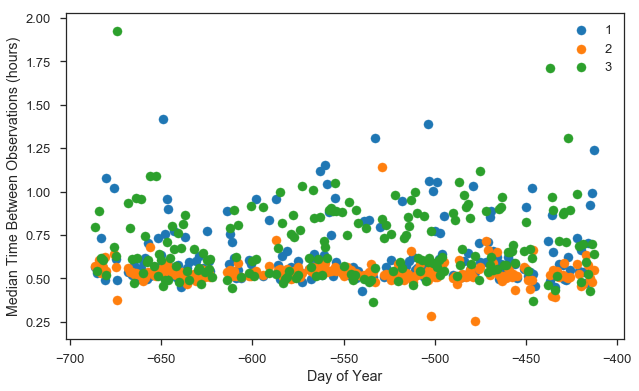

In [21]:
gap = intranight_gap*24.
gap = gap.reset_index()
grp_np = gap.groupby(['night','propID'])
intranight_gap_night_prop = grp_np.agg(np.median)
intranight_gap_night_prop = intranight_gap_night_prop.reset_index()
for prop in [1,2,3]:
    w = intranight_gap_night_prop['propID'] == prop
    plt.scatter(intranight_gap_night_prop.loc[w,'night'], intranight_gap_night_prop.loc[w,'expMJD'], label=prop)
plt.legend()
plt.xlabel('Day of Year')
plt.ylabel('Median Time Between Observations (hours)')
plt.savefig(f'fig/{sim_name}/intranight_gap_by_doy.png')

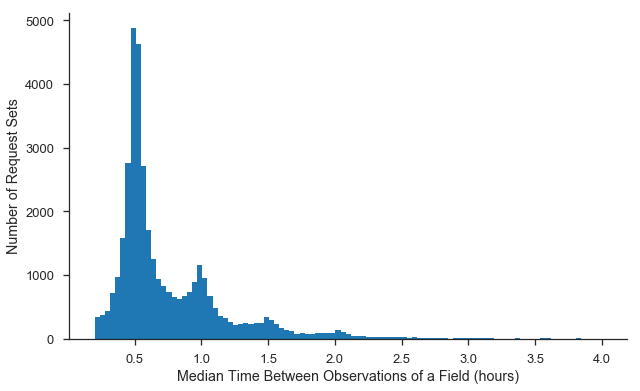

In [22]:
plt.hist(gap.loc[gap['expMJD'].notnull(),'expMJD'],bins=np.linspace(0.2,4,100))
plt.xlabel('Median Time Between Observations of a Field (hours)')
plt.ylabel('Number of Request Sets')
sns.despine()
plt.savefig(f'fig/{sim_name}/intranight_gap_hist.png')

In [23]:
night_min = intranight_grp['expMJD'].agg(np.min)
night_max = intranight_grp['expMJD'].agg(np.max)
night_max = night_max.reset_index('night')
night_min = night_min.reset_index('night')

# not quite right--need to subtract night from night
#intranight_gap = night_max.values[:-1] - night_min.values[1:] 

In [24]:
intranight_gap = {}
for idx in night_min.index:
    intranight_gap[idx] = np.median(night_min.loc[idx,'expMJD'].values[1:] - night_max.loc[idx,'expMJD'].values[:-1])

/Users/ebellm/anaconda3/envs/ztf_sim/lib/python3.6/site-packages/pandas/core/indexing.py:1325: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/Users/ebellm/anaconda3/envs/ztf_sim/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ebellm/anaconda3/envs/ztf_sim/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
intranight_df = pd.DataFrame.from_dict(intranight_gap,orient='index')

In [26]:
intranight_df = intranight_df.reset_index()

In [27]:
intranight_df['propID'] = intranight_df['index'].apply(lambda x: x[0])
intranight_df['fieldID'] = intranight_df['index'].apply(lambda x: x[1])

In [28]:
intranight_df.head()

,index,0,propID,fieldID
0,"(1, 257)",3.937569,1,257
1,"(1, 258)",4.937213,1,258
2,"(1, 259)",4.000025,1,259
3,"(1, 260)",1.967431,1,260
4,"(1, 307)",3.002759,1,307


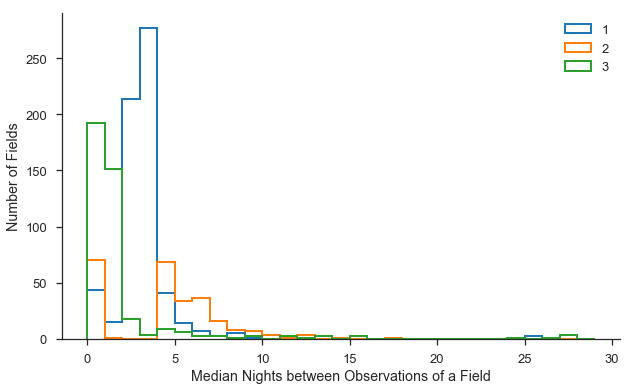

In [29]:
for prop in [1,2,3]:
    w = (intranight_df['propID'] == prop) & intranight_df[0].notnull()
    plt.hist(intranight_df.loc[w,0], bins=np.arange(0,30),label=f'{prop}',histtype='step',linewidth=2)
plt.legend()
plt.xlabel('Median Nights between Observations of a Field')
plt.ylabel('Number of Fields')
sns.despine()
plt.savefig(f'fig/{sim_name}/internight_gap_hist.png')

(array([  3515.,   6041.,  13031.,  21191.,  24033.,  21242.,  15928.,
          8744.,   4177.,   1445.]),
 array([  18.61669562,   34.72008075,   50.82346589,   66.92685102,
          83.03023615,   99.13362128,  115.23700641,  131.34039154,
         147.44377668,  163.54716181,  179.65054694]),
 <a list of 10 Patch objects>)

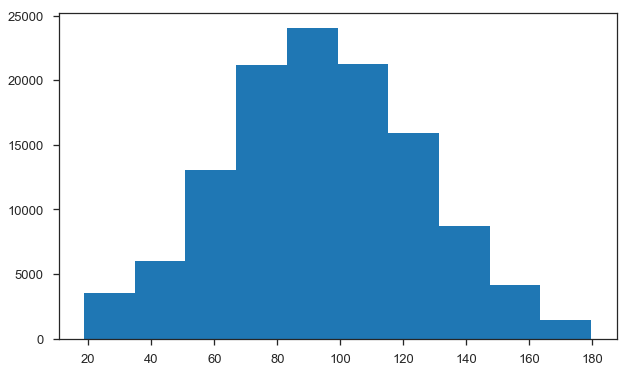

In [30]:
plt.hist(np.degrees(df.dist2Moon))